In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import pickle

In [2]:
# load data
df_edges = pd.read_csv("../data/musae_git_edges.csv")
df_nodes = pd.read_csv("../data/musae_git_target.csv")

In [3]:
df_nodes.head()

,id,name,ml_target
0,0,Eiryyy,0
1,1,shawflying,0
2,2,JpMCarrilho,1
3,3,SuhwanCha,0
4,4,sunilangadi2,1


In [4]:
df_edges.head()

,id_1,id_2
0,0,23977
1,1,34526
2,1,2370
3,1,14683
4,1,29982


In [5]:
# create graph
G = nx.Graph()

# Add nodes to the graph
for index, row in df_nodes.iterrows():
    G.add_node(row['id'], status=row['ml_target'])

# Add edges to the graph
for index, row in df_edges.iterrows():
    G.add_edge(row['id_1'], row['id_2'])

In [6]:
def run_simulation(G, beta, gamma, max_iter=False):
    # Initialize influence and recovery attributes for each node
    num_infected = []
    num_recovered = []
    num_susceptible = []
    iter = 0

    # initially, no node has been processed or influenced anyone
    for node in G.nodes:
        G.nodes[node]['influence'] = 0
        G.nodes[node]['processed'] = 0
    
    # Perform the contagion simulation
    while True:
        if max_iter == iter:
            break
        
        # Select an infected node that has not yet recovered
        infected_nodes = [node for node, data in G.nodes(data=True) if data['status'] == 1]
        overall_susceptible = [node for node, data in G.nodes(data=True) if data['status'] == 0]
        recovered_nodes = [node for node, data in G.nodes(data=True) if data['status'] == 2]
        
        # add number of each node group for plotting
        num_infected.append(len(infected_nodes))
        num_susceptible.append(len(overall_susceptible))
        num_recovered.append(len(recovered_nodes))

        if not infected_nodes:  # if no more active infected nodes
            break
        node = np.random.choice(infected_nodes)
        G.nodes[node]['processed'] = 1

        # List its susceptible neighbors
        susceptible_neighbors = [n for n in G.neighbors(node) if G.nodes[n]['status'] == 0]

        # Infect susceptible neighbors with probability beta
        for n in susceptible_neighbors:
            G.nodes[n]['processed'] = 1
            if np.random.random() <= beta:
                G.nodes[n]['status'] = 1  # Change to infected
                G.nodes[node]['influence'] += 1  # Increase influence of the infecting node

        # Recovery process for infected node with probability gamma
        if np.random.random() <= gamma:
            G.nodes[node]['status'] = 2  # Change to recovered
            
        iter += 1
    
    return G, num_infected, num_susceptible, num_recovered, iter, beta, gamma

Skip this line and maybe load pickle file. Computation takes about 58 mins on MacBookPro 2017 13"

In [7]:
result_groups = []
result_groups.append(run_simulation(G.copy(), 0.3, 0.2, max_iter=50000))
result_groups.append(run_simulation(G.copy(), 0.5, 0.2, max_iter=50000))
result_groups.append(run_simulation(G.copy(), 0.5, 0.3, max_iter=50000))
result_groups.append(run_simulation(G.copy(), 0.7, 0.3, max_iter=50000))
result_groups.append(run_simulation(G.copy(), 0.7, 0.5, max_iter=50000))
result_groups.append(run_simulation(G.copy(), 1.0, 0.5, max_iter=50000))

In [8]:
file_path = 'result_groups.pickle'
with open(file_path, "wb") as file:
    pickle.dump(result_groups, file)

# with open(file_path, "rb") as file:
#     result_groups = pickle.load(file)

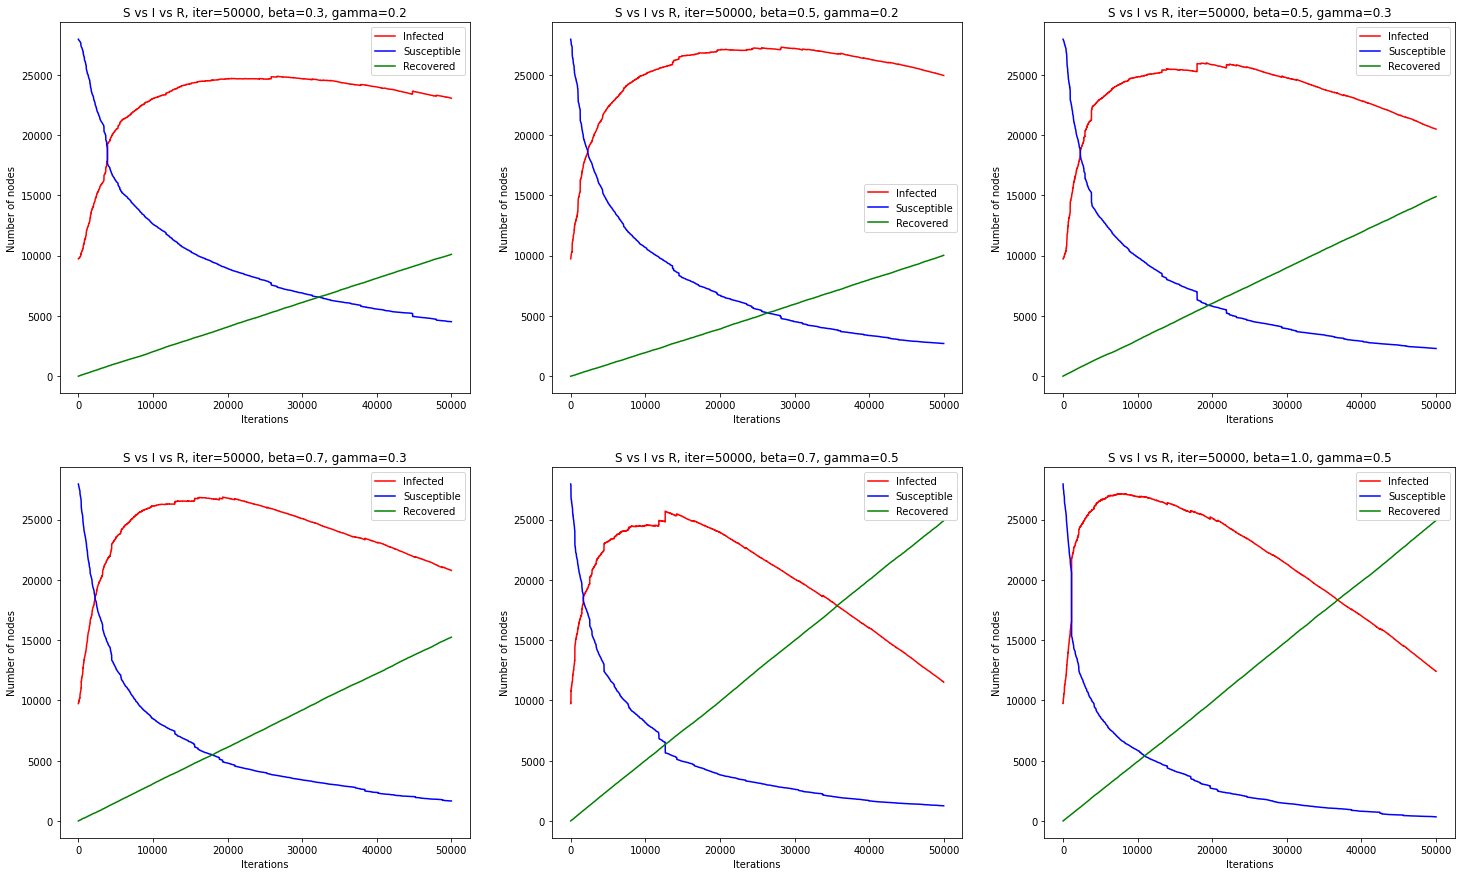

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 15))
axs=axs.flatten()

for ax, results in zip(axs, result_groups):
    x_val = range(results[4])
    title = f"S vs I vs R, iter={results[4]}, beta={results[5]}, gamma={results[6]}"

    ax.plot(x_val, results[1], color='red', label='Infected')
    ax.plot(x_val, results[2], color='blue', label='Susceptible')
    ax.plot(x_val, results[3], color='green', label='Recovered')
    ax.legend()

    ax.set_xlabel("Iterations")
    ax.set_ylabel("Number of nodes")
    
    ax.set_title(title)

fig.savefig(f"plots/simple-contagion.jpg", bbox_inches='tight', dpi=300)
fig.savefig(f"plots/simple-contagion-smallsize.jpg", bbox_inches='tight', dpi=150)
plt.show()   


In [10]:
df_list = []
for results in result_groups:
    # Get the node attributes as a dictionary
    node_dict = nx.get_node_attributes(results[0], 'status')
    influence_dict = nx.get_node_attributes(results[0], 'influence')
    processed_dict = nx.get_node_attributes(results[0], 'processed')

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame({
        'id': node_dict.keys(),
        'status': node_dict.values(),
        'influence': influence_dict.values(),
        'processed': processed_dict.values()
    })
    df_list.append(df)

In [11]:
# get the nodes from the graph with the most connections
sorted_influential = dict(sorted(nx.degree_centrality(G).items(), key=lambda x: x[1], reverse=True))
top_20_infl = dict(list(sorted_influential.items())[:20])
top_20_infl

{31890: 0.25088198625958247,
 27803: 0.18793601952306427,
 35773: 0.08817210005570439,
 19222: 0.07846361972466113,
 13638: 0.06546592747818245,
 36652: 0.062150189660203185,
 18163: 0.05103583649433672,
 9051: 0.04766704687126979,
 35008: 0.0416721928963633,
 10001: 0.041592615188731794,
 36628: 0.03997453513355792,
 7027: 0.039390965277593566,
 19253: 0.03724236717154301,
 2078: 0.03628743467996499,
 33671: 0.03573039072654447,
 5629: 0.03490808774768561,
 73: 0.03360831852303774,
 3712: 0.033528740815406244,
 11051: 0.03289211915435423,
 30002: 0.027984827183744926}

In [14]:
# show the nodes that have infected the most nodes and check if these also coincide with 
# the nodes with the most connections

top_ids = []
for df in df_list:
    top_infl = df.sort_values('influence', ascending=False).head()
    print(top_infl)
    print(" ")

    common_ids = set(top_infl['id'].tolist()).intersection(set(top_20_infl.keys()))
    top_ids += list(common_ids)
    print(f"Common IDs from top influential nodes and most connected nodes: {common_ids}")
    print(" ")

          id  status  influence  processed
31890  31890       1       1615          1
13638  13638       1        483          1
19222  19222       1        460          1
18163  18163       2        429          1
14242  14242       2        229          1
 
Common IDs from top influential nodes and most connected nodes: {31890, 18163, 13638, 19222}
 
          id  status  influence  processed
35773  35773       1       1045          1
2078    2078       1        767          1
19253  19253       1        459          1
7027    7027       1        434          1
30199  30199       2        263          1
 
Common IDs from top influential nodes and most connected nodes: {7027, 19253, 2078, 35773}
 
          id  status  influence  processed
13638  13638       2       1066          1
31890  31890       2        945          1
27803  27803       1        856          1
18163  18163       1        528          1
14242  14242       2        450          1
 
Common IDs from top influential 

In [15]:
# count the coinciding nodes and on how many simulations they appear as the most influential
counted_ids = dict(sorted(Counter(top_ids).items(), key=lambda x: x[1], reverse=True))
counted_ids

{31890: 4,
 18163: 3,
 13638: 3,
 19253: 2,
 35773: 2,
 19222: 1,
 7027: 1,
 2078: 1,
 27803: 1,
 73: 1,
 36652: 1,
 11051: 1}

In [16]:
# display their initial status
df_nodes_indexed = df_nodes.set_index("id")
df_nodes_indexed.loc[list(counted_ids.keys())]

,name,ml_target
id,,
31890,dalinhuang99,0
18163,nelsonic,0
13638,gabrielpconceicao,0
19253,JonnyBanana,0
35773,addyosmani,0
19222,Bunlong,0
7027,jeresig,0
2078,mbostock,0
27803,nfultz,0


In [17]:
# get the nodes from the graph with the least connections that are ML devs
sorted_disatvantage = dict(sorted(nx.degree_centrality(G).items(), key=lambda x: x[1], reverse=False))
least_inf_ml = list(df_nodes_indexed.loc[list(sorted_disatvantage.keys())][df_nodes_indexed['ml_target'] == 1].head(n=20).index)
least_inf_ml

/var/folders/q2/wz31b41120l4chrx6_0zn1ym0000gn/T/ipykernel_1877/1228448069.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  least_inf_ml = list(df_nodes_indexed.loc[list(sorted_disatvantage.keys())][df_nodes_indexed['ml_target'] == 1].head(n=20).index)


[2,
 37,
 59,
 62,
 77,
 79,
 153,
 170,
 172,
 196,
 209,
 217,
 220,
 234,
 245,
 247,
 267,
 289,
 299,
 331]

In [19]:
# since simulations take to long to terminate, we consider the nodes who were visited at least once
# during the sumulation

bot_ids = []
for df in df_list:
    bot_infl = df[df['processed'] == 1].sort_values('influence', ascending=True).head()
    print(bot_infl)
    print(" ")

          id  status  influence  processed
0          0       1          0          1
23824  23824       1          0          1
23823  23823       0          0          1
23822  23822       2          0          1
23821  23821       1          0          1
 
          id  status  influence  processed
0          0       1          0          1
23785  23785       0          0          1
23784  23784       1          0          1
23783  23783       1          0          1
23782  23782       1          0          1
 
          id  status  influence  processed
0          0       0          0          1
23943  23943       1          0          1
23942  23942       2          0          1
23941  23941       1          0          1
23940  23940       1          0          1
 
          id  status  influence  processed
0          0       0          0          1
23801  23801       1          0          1
23800  23800       1          0          1
23799  23799       1          0          1
23798